In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
import torch
from torch.optim import Adam, SGD, Adamax
from sklearn.preprocessing import MinMaxScaler

# Models
First let's define our models, and the baseline model (ModelReLU). The latter will be used to compare our model in the defined task.

In [2]:
from localized_look.model import LoLoLayer


class ModelLoLo(nn.Module):
    def __init__(self, activation="invsquare"):
        super().__init__()
        self.layer = nn.Sequential(
            LoLoLayer(n_kernels=120, n_channels=2, fusion="channels", activation=activation),
            nn.LeakyReLU(.05),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layer(x)

class ModelReLU(nn.Module):
    
    def __init__(self):
        super().__init__()
        n = 64
        self.layer = nn.Sequential(
            nn.Linear(2, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, n),
            nn.LeakyReLU(.05),
            nn.Linear(n, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer(x)

In [3]:
model_lolo = ModelLoLo()
model_relu = ModelReLU()

In [4]:
model_lolo

ModelLoLo(
  (layer): Sequential(
    (0): LoLoLayer(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=120, bias=True)
          (1): LoLoInvSquare()
        )
        (1): Sequential(
          (0): Linear(in_features=1, out_features=120, bias=True)
          (1): LoLoInvSquare()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=120, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [5]:
for param in list(model_lolo.layer.children())[0].parameters():
    print(param)

Parameter containing:
tensor([[[ 0.0104,  0.7441],
         [-0.4554, -0.9809],
         [-0.2473,  0.9596],
         [ 0.7498,  0.1477],
         [-0.2009, -0.3338],
         [-0.2050,  0.0347],
         [ 0.9328,  0.2414],
         [-0.3696,  0.7528],
         [ 0.9518, -0.6326],
         [-0.2394,  0.1649],
         [-0.1539,  0.0906],
         [-0.6008,  0.6365],
         [-0.1278, -0.5510],
         [-0.8615,  0.2027],
         [-0.1317,  0.8025],
         [-0.0661,  0.8239],
         [-0.8768, -0.9777],
         [ 0.2114,  0.3492],
         [ 0.3203, -0.7709],
         [ 0.5365, -0.0698],
         [-0.2932,  0.0429],
         [ 0.9631,  0.5415],
         [-0.2711, -0.0256],
         [-0.8857,  0.8518],
         [ 0.4704, -0.7630],
         [ 0.7301, -0.1646],
         [-0.1178, -0.0722],
         [ 0.9302, -0.3632],
         [ 0.8648,  0.1140],
         [ 0.4230,  0.1111],
         [-0.9113, -0.4510],
         [ 0.1353,  0.8888],
         [-0.4212, -0.4574],
         [ 0.9932,  0

In [6]:
model_relu

ModelReLU(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

# Benchmark
Our dataset will be a "checkerboard" like, i.e., with sparse locals where the label is one. The net figure is a visualization of this. There is 2 features (X and Y).

In [7]:
from torch.utils.data import DataLoader, Dataset
from localized_look.utils import create_labels_checker


class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
#         self.w = w
        assert len(x) == len(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]#, self.w[i]


scaler = MinMaxScaler(feature_range=(-5, 5))
    
x = np.random.rand(50000, 2)*250-125
y = create_labels_checker(x, 10, size=7, stride=25, start=-100)
# y = ((x > -15) & (x < - 5)) | ((x > 5) & (x < 15)) 

w = (y * .9 + .05).flatten()

idx = np.random.choice(np.arange(len(x)), size=3000, p=w/w.sum() , replace=False)

x = x[idx]
y = y[idx]

print(y.mean())

x = scaler.fit_transform(x)

x_true, y_true = x.copy(), y.copy()

x, y = torch.Tensor(x), torch.Tensor(y)

trainloader = torch.utils.data.DataLoader(
    dataset(x, y),
    batch_size=64,
    shuffle=True,
    num_workers=0
)
_ = model_lolo(x), model_relu(x)

0.476


Just checking that all models are comparable in the number of parameters (the ReLU model has 6 more parameters).

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("LoLo model n parameters:", count_parameters(model_lolo))
print("ReLU model n parameters:", count_parameters(model_relu))

LoLo model n parameters: 961
ReLU model n parameters: 4321


This is our training data. We can see that the label (Z axis) is 1 in specific points of the dataset.

Text(0.5, 0, 'Label')

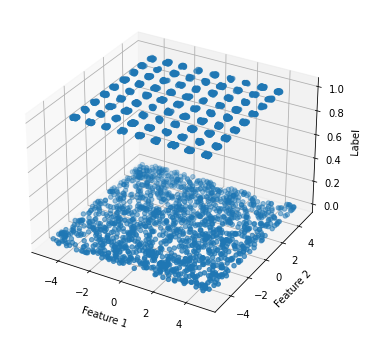

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], y)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111)

# ax.scatter(x[:, 0], y)

In [10]:
from torch.optim.optimizer import Optimizer, required
import math

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

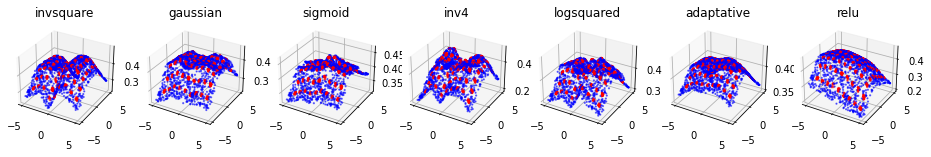

Epoch 0 :
invsquare loss:0.694, Mean batch time: 3.424ms
gaussian loss:0.695, Mean batch time: 3.296ms
sigmoid loss:0.710, Mean batch time: 3.466ms
inv4 loss:0.695, Mean batch time: 3.658ms
logsquared loss:0.696, Mean batch time: 3.169ms
adaptative loss:0.699, Mean batch time: 4.189ms
relu loss:0.703, Mean batch time: 1.829ms


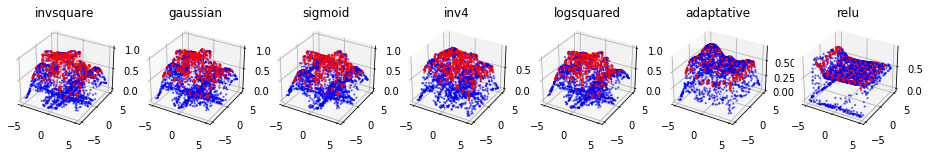

Epoch 25 :
invsquare loss:0.468, Mean batch time: 3.188ms
gaussian loss:0.484, Mean batch time: 3.171ms
sigmoid loss:0.496, Mean batch time: 3.299ms
inv4 loss:0.479, Mean batch time: 3.573ms
logsquared loss:0.487, Mean batch time: 3.299ms
adaptative loss:0.640, Mean batch time: 4.210ms
relu loss:0.624, Mean batch time: 1.766ms


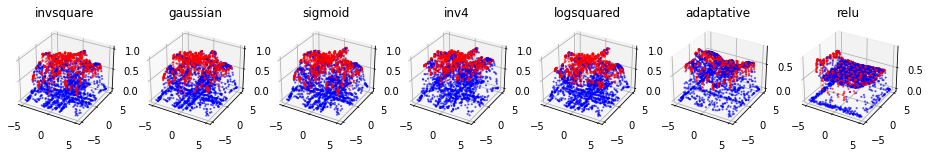

Epoch 50 :
invsquare loss:0.373, Mean batch time: 3.165ms
gaussian loss:0.406, Mean batch time: 3.131ms
sigmoid loss:0.399, Mean batch time: 3.274ms
inv4 loss:0.396, Mean batch time: 3.530ms
logsquared loss:0.395, Mean batch time: 3.247ms
adaptative loss:0.565, Mean batch time: 4.176ms
relu loss:0.608, Mean batch time: 1.737ms


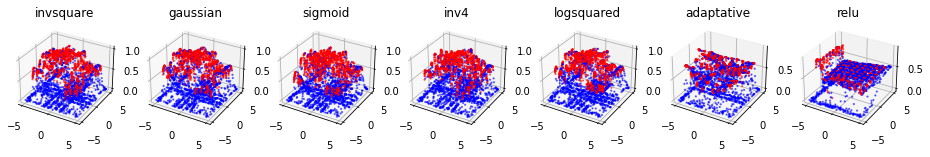

Epoch 75 :
invsquare loss:0.314, Mean batch time: 3.164ms
gaussian loss:0.361, Mean batch time: 3.123ms
sigmoid loss:0.327, Mean batch time: 3.264ms
inv4 loss:0.350, Mean batch time: 3.531ms
logsquared loss:0.346, Mean batch time: 3.233ms
adaptative loss:0.514, Mean batch time: 4.192ms
relu loss:0.596, Mean batch time: 1.694ms


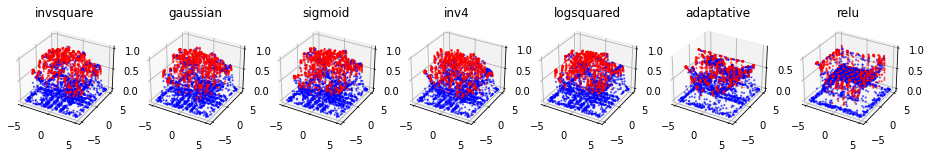

Epoch 100 :
invsquare loss:0.283, Mean batch time: 3.180ms
gaussian loss:0.303, Mean batch time: 3.131ms
sigmoid loss:0.275, Mean batch time: 3.268ms
inv4 loss:0.328, Mean batch time: 3.539ms
logsquared loss:0.313, Mean batch time: 3.249ms
adaptative loss:0.488, Mean batch time: 4.207ms
relu loss:0.544, Mean batch time: 1.741ms


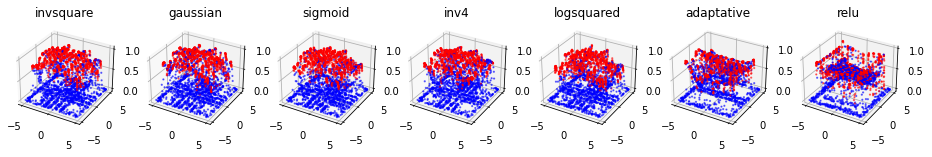

Epoch 125 :
invsquare loss:0.246, Mean batch time: 3.209ms
gaussian loss:0.267, Mean batch time: 3.159ms
sigmoid loss:0.242, Mean batch time: 3.290ms
inv4 loss:0.300, Mean batch time: 3.570ms
logsquared loss:0.271, Mean batch time: 3.280ms
adaptative loss:0.455, Mean batch time: 4.238ms
relu loss:0.527, Mean batch time: 1.710ms


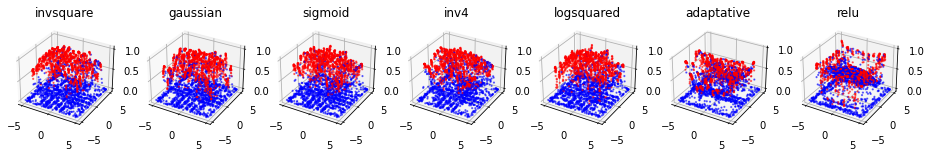

Epoch 150 :
invsquare loss:0.215, Mean batch time: 3.198ms
gaussian loss:0.252, Mean batch time: 3.149ms
sigmoid loss:0.222, Mean batch time: 3.286ms
inv4 loss:0.291, Mean batch time: 3.567ms
logsquared loss:0.231, Mean batch time: 3.275ms
adaptative loss:0.436, Mean batch time: 4.238ms
relu loss:0.513, Mean batch time: 1.723ms


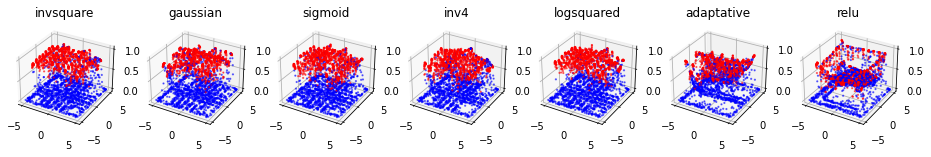

Epoch 175 :
invsquare loss:0.197, Mean batch time: 3.208ms
gaussian loss:0.235, Mean batch time: 3.159ms
sigmoid loss:0.202, Mean batch time: 3.302ms
inv4 loss:0.272, Mean batch time: 3.582ms
logsquared loss:0.193, Mean batch time: 3.288ms
adaptative loss:0.416, Mean batch time: 4.247ms
relu loss:0.519, Mean batch time: 1.662ms


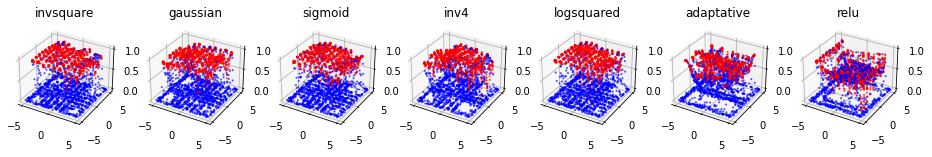

Epoch 200 :
invsquare loss:0.181, Mean batch time: 3.198ms
gaussian loss:0.194, Mean batch time: 3.147ms
sigmoid loss:0.186, Mean batch time: 3.293ms
inv4 loss:0.272, Mean batch time: 3.571ms
logsquared loss:0.179, Mean batch time: 3.278ms
adaptative loss:0.393, Mean batch time: 4.236ms
relu loss:0.494, Mean batch time: 1.731ms


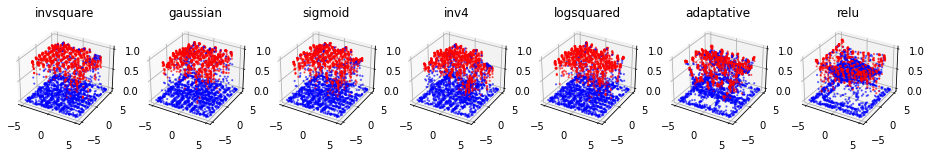

Epoch 225 :
invsquare loss:0.168, Mean batch time: 3.195ms
gaussian loss:0.163, Mean batch time: 3.144ms
sigmoid loss:0.173, Mean batch time: 3.289ms
inv4 loss:0.251, Mean batch time: 3.573ms
logsquared loss:0.153, Mean batch time: 3.282ms
adaptative loss:0.369, Mean batch time: 4.234ms
relu loss:0.489, Mean batch time: 1.738ms


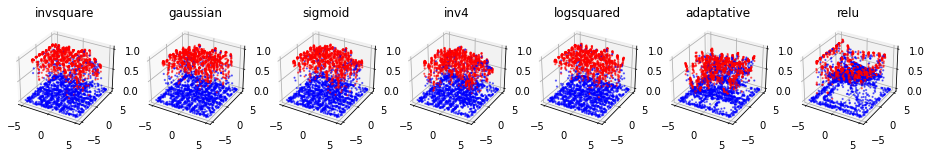

Epoch 250 :
invsquare loss:0.159, Mean batch time: 3.191ms
gaussian loss:0.147, Mean batch time: 3.137ms
sigmoid loss:0.164, Mean batch time: 3.286ms
inv4 loss:0.246, Mean batch time: 3.568ms
logsquared loss:0.144, Mean batch time: 3.278ms
adaptative loss:0.352, Mean batch time: 4.226ms
relu loss:0.476, Mean batch time: 1.689ms


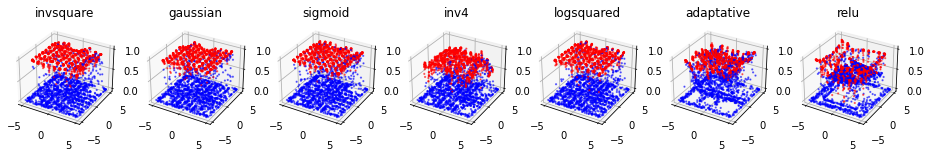

Epoch 275 :
invsquare loss:0.149, Mean batch time: 3.195ms
gaussian loss:0.127, Mean batch time: 3.141ms
sigmoid loss:0.158, Mean batch time: 3.287ms
inv4 loss:0.230, Mean batch time: 3.573ms
logsquared loss:0.140, Mean batch time: 3.282ms
adaptative loss:0.356, Mean batch time: 4.230ms
relu loss:0.456, Mean batch time: 1.701ms


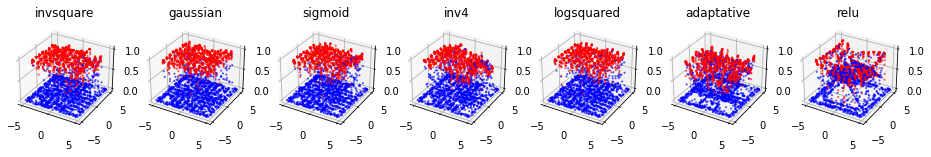

Epoch 300 :
invsquare loss:0.146, Mean batch time: 3.190ms
gaussian loss:0.109, Mean batch time: 3.136ms
sigmoid loss:0.152, Mean batch time: 3.281ms
inv4 loss:0.229, Mean batch time: 3.562ms
logsquared loss:0.136, Mean batch time: 3.278ms
adaptative loss:0.333, Mean batch time: 4.221ms
relu loss:0.447, Mean batch time: 1.685ms


RuntimeError: all elements of input should be between 0 and 1

In [14]:
from localized_look.utils import weight_init
import localized_look.activation as act
import time

activations = act.ACTIVATION_DICT

models = {act:ModelLoLo(activation=act) for act in activations}
models.update(
    {
        "relu": ModelReLU()
    }
)

for model in models.values():
    model.apply(weight_init)
    model.train()

optimizers = {model_key:Adam(models[model_key].parameters(), lr=1e-2) for model_key in models}
# optimizers = {model_key:SGD(models[model_key].parameters(), lr=1e-3) for model_key in models}
# optimizers = {model_key:Adamax(models[model_key].parameters(), lr=1e-2) for model_key in models}
# optimizers = {model_key:RAdam(models[model_key].parameters()) for model_key in models}

loss_fn = nn.BCELoss()

times = {model_key:[] for model_key in models}
for epoch in range(700):
    losses = {model_key:[] for model_key in models}
    for x, y in trainloader:
        for optim in optimizers.values():
            optim.zero_grad()
        # ModelLoLo
        for model_key in models:
            start_time = time.time()
            pred = models[model_key].forward(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizers[model_key].step()
            losses[model_key] += [loss.item()]
            end_time = time.time()
            delta = end_time - start_time
            times[model_key] += [delta]
    # Calculate mean time using the last 5 epochs
    times[model_key] =  times[model_key][-len(trainloader)*5:]
    if epoch % 25 == 0:
        
        x, y = x_true, y_true

        fig = plt.figure(figsize=(16, 6))
        if x.shape[1] == 2:
            axes = [fig.add_subplot(100 + len(models)*10 + i + 1, projection='3d') for i in range(len(models))]
            for i, model_key in enumerate(models):
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], x[:, 1], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        if x.shape[1] == 1:
            axes = [fig.add_subplot(100 + len(models)*10 + i + 1) for i in range(len(models))]
            for i, model_key in enumerate(models):
                interm = list(list(models[model_key].layer.children())[0].layers.children())[0]
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                a, b = x_true.flatten(), interm.forward(torch.Tensor(x_true)).detach().numpy()
                for j in range(b.shape[1]):
                    axes[i].scatter(a, b[:, j], alpha=.2, s=1., cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        
        print("Epoch", epoch, ":")
        for model_key in models:
            print(
                "{} loss:{:.3f}, Mean batch time: {:.3f}ms".format(
                    model_key,
                    np.mean(losses[model_key]),
                    np.mean(times[model_key])*1000,
                )
            )

In [13]:
model_key

'adaptative'

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print("Balanced accuracy scores")
for i, model_key in enumerate(models):
    pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy().flatten()
    pred = (pred > .5)
    score = balanced_accuracy_score(y_true, pred)
    print("{}: {:.3f}".format(model_key, score))


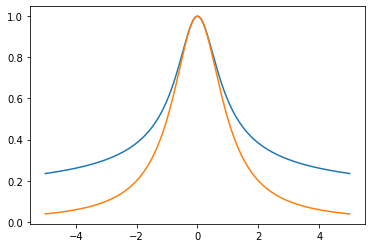

In [30]:
from localized_look import activation as act
x = np.linspace(-5, 5, 1000)
y = 1/(1 + np.log(x**2 + 1))
y_ = 1/(x**2 + 1)
plt.plot(x, y)
plt.plot(x, y_)
torch.log

In [ ]:
# x_ = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_ = np.concatenate([np.linspace(-2, 2, 100).reshape(-1, 1), np.linspace(-2, 2, 100).reshape(-1, 1)], axis=1)
x = torch.Tensor(x_)
m = list(model.layer.children())[0]
pred = m(x).detach()
# plt.plot(x_, pred)
# plt.show()
plt.plot(x_, model.forward(torch.Tensor(x_)).detach())
# plt.show()
# plt.plot(x_true, y_true)


In [ ]:
x= np.linspace(-3, 3, 1000)
mu, std = 0, 1
y1 = (1/(np.pi*(2*std)**.5))*np.exp(-.5*(x-mu)**2/std)
y2 = 1/(x**2 + 1)/5
plt.plot(x, y1)
plt.plot(x, y2)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# x = np.random.rand(1000, 2)
# a, b = x.T
# y = ((a < .4) & ( a > .1) &  (b < .9) & ( b > .5)) | ((a > .7) & ( a < .9) &  (b > .1) & ( b < .6))
x, y = x_true, y_true
pred = model.forward(torch.Tensor(x)).detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x[:, 0], x[:, 1], y, c=(pred>.5).astype(int).flatten())
ax.scatter(x[:, 0], x[:, 1], pred, c=y)
# ax.scatter(x[:, 0], x[:, 1], (pred>.2).astype(int).flatten(), c=y)


In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)*(1.2-sigmoid(x))
plt.plot(x, y)